In [6]:
# !nvidia-smi

In [49]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X, y = make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES,random_state=RANDOM_SEED,cluster_std=1.5)


In [50]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=RANDOM_SEED)

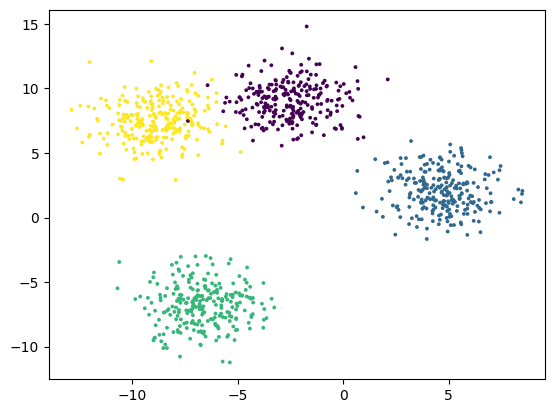

In [51]:
# Plotting

plt.scatter(X[:,0],X[:,1],c=y,s=3)

## Building a multi-class classifcation

In [52]:
class BlobModel(nn.Module):
    def __init__(self,input_features, output_features,hidden_units=8):
        super().__init__()

        self.linear_layer_stack = nn.Sequential( nn.Linear(input_features,hidden_units),
                                                nn.ReLU(),
                                                nn.Linear(hidden_units,hidden_units),
                                                nn.ReLU(),
                                                nn.Linear(hidden_units,output_features))
    
    def forward(self,x):
        return self.linear_layer_stack(x)

torch.manual_seed(42)
model_4 = BlobModel(2,4,hidden_units=8)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Compile and Train the Model

In [53]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.01)

torch.manual_seed(RANDOM_SEED)

epochs = 200
preds = []

for epoch in range(epochs):

    model_4.train()

    y_logits = model_4(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)


    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logit = model_4(X_test)
        test_pred = torch.softmax(test_logit, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logit, y_test)
        preds.append([y_pred.detach().numpy(),test_pred.numpy(),loss,test_loss,epoch])
    
    if epoch%10 == 0:
        print(f"Epoch:{epoch} | Loss: {loss} | Test Loss: {test_loss}")



Epoch:0 | Loss: 1.1588267087936401 | Test Loss: 1.1472400426864624
Epoch:10 | Loss: 1.0649317502975464 | Test Loss: 1.0684112310409546
Epoch:20 | Loss: 0.9818969964981079 | Test Loss: 0.9975585341453552
Epoch:30 | Loss: 0.9113848805427551 | Test Loss: 0.9360029697418213
Epoch:40 | Loss: 0.8528527021408081 | Test Loss: 0.8834068179130554
Epoch:50 | Loss: 0.8042965531349182 | Test Loss: 0.838513970375061
Epoch:60 | Loss: 0.7635005712509155 | Test Loss: 0.799843966960907
Epoch:70 | Loss: 0.7284805178642273 | Test Loss: 0.765947699546814
Epoch:80 | Loss: 0.6976862549781799 | Test Loss: 0.7355577349662781
Epoch:90 | Loss: 0.6697836518287659 | Test Loss: 0.7075848579406738
Epoch:100 | Loss: 0.6438220143318176 | Test Loss: 0.6811697483062744
Epoch:110 | Loss: 0.6191200017929077 | Test Loss: 0.6557323932647705
Epoch:120 | Loss: 0.5951602458953857 | Test Loss: 0.6307743787765503
Epoch:130 | Loss: 0.5715956687927246 | Test Loss: 0.6060196757316589
Epoch:140 | Loss: 0.5484097003936768 | Test Loss

In [54]:
model_4.eval()
with torch.inference_mode():
    y_logit = model_4(X_test)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

MovieWriter ffmpeg unavailable; using Pillow instead.


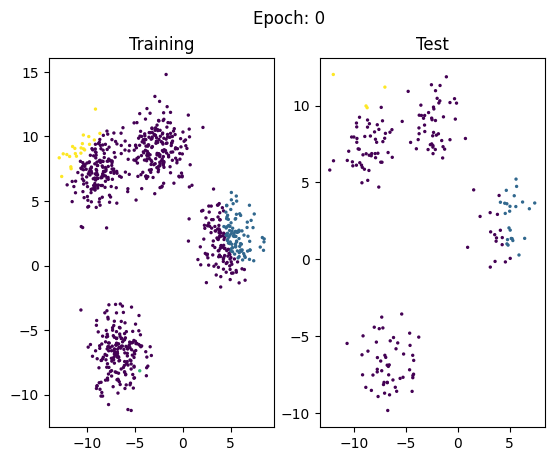

In [105]:
fig,ax = plt.subplots(1,2)

def f(frame):

    ax[0].clear()
    ax[0].scatter(X_train[:,0],X_train[:,1],c=frame[0],s=2)
    ax[0].set_title("Training")

    ax[1].clear()
    ax[1].scatter(X_test[:,0],X_test[:,1],c=frame[1],s=2)
    ax[1].set_title("Test")
    plt.suptitle(f"Epoch: {frame[-1]}")

    return ax,

ani = FuncAnimation(fig, f, frames=preds, interval=50)

ani.save("multiclass_classification.gif",fps=30)

